<div style="background-color: #f9f9a9; padding: 2px; border-radius: 1px;font-size:20px;font-weight:bold;">
  실무 활용 과정
</div>

## 동적 웹 페이지 크롤링
* 설치 및 사용법 
   > (필수)<font color=blue>pip install selenium</font>  
   > (필수)<font color=blue>pip install webdriver_manager</font> **`ChromeDriver 자동관리(webdriver_manager)`**  
   > (필수)<font color=blue>pip install bs4 pandas requests</font> **`네트워크 및 데이터 처리 도구`**  
   > WebDriver 다운로드 : https://www.selenium.dev/downloads  
   > 사용법 소개: https://www.selenium.dev/documentation/  


In [ ]:
!pip install selenium

In [ ]:
!pip install webdriver_manager

In [ ]:
!pip install bs4 requests pandas

## **`CoffeeBean`** 매장 자동 검색
* [커피빈 홈 https://www.coffeebeankorea.com/main/main.asp](https://www.coffeebeankorea.com/main/main.asp)  
* [매장찾기 https://www.coffeebeankorea.com/store/store.asp](https://www.coffeebeankorea.com/store/store.asp)

1. 매장번호를 마우스 클릭
   
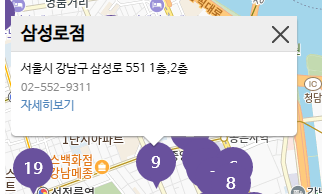  
2. 파업메뉴의 **`자세히보기`** 마우스 클릭  

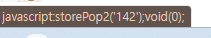  

3. 매장 정보 확인 및 마우스 오른쪽버튼 &lt; 파업메뉴 중 **`검사`** 클릭하여 소스 확인

In [ ]:
# selenium 예시(2) 
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import datetime

def CoffeeBean_store(result):
    url = "https://www.coffeebeankorea.com/store/store.asp"
    #크롬 드라이버 생성
    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
    for i in range(1,100): # 기본 10개 매장만, 매장 수만큼 반복 300
        #커피빈 웹사이트 접속
        driver.get(url)
        time.sleep(1)
        try:
            # 커피빈 매장 정보 - 자바스크립트 함수 호출
            driver.execute_script("storePop2(%d)" % i)
            time.sleep(1)
            
            # 자바스크립트 함수가 수행된 페이지 저장
            html = driver.page_source
            
            # BeautifulSoup 객체 생성
            soup = BeautifulSoup(html,'html.parser')
            #print(soup.prettify())
            store_name_h2 = soup.select("div.store_txt > h2")
            store_name = store_name_h2[0].string
            print(store_name) #매장 이름 출력
            store_info = soup.select("div.store_txt > table.store_table > tbody > tr > td")
            store_address_list = list(store_info[2])
            store_address = store_address_list[0]
            store_phone = store_info[3].string
            result.append([store_name]+[store_address]+[store_phone])
        except:
            continue
    # 결과 페이지 스크린샷 저장
    driver.save_screenshot('CoffeeBean_results.png')
    #브라우저 종료
    driver.quit()
    return

def main():
    result = []
    print('CoffeeBean store crawling')
    CoffeeBean_store(result)
    CB_tb1 = pd.DataFrame(result, columns = ['store','address','phone'])
    CB_tb1.to_csv('CoffeeBean_info.csv', encoding='utf8', mode= 'w', index=True)

if __name__ == '__main__':
    main()            


## 위에서 생성된 데이터를 기준으로 DB 테이블 생성
* 먼저, 위 코드를 실행한다. 
* <font color=blue><b>ChatGPT 실행</b></font>: <font color=green><b>csv 파일업로드 후<b></font> 
* 프롬프트 요청: <font color=red><b>`이 파일을 기초로 MySQL 테이블을 만들어줘`</b></font>

```mysql
-- 선택: MySQL DB 생성
CREATE DATABASE IF NOT EXISTS coffee DEFAULT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci;
USE coffee;

-- 테이블 생성
CREATE TABLE coffee_stores (
  id INT UNSIGNED NOT NULL AUTO_INCREMENT,
  store   VARCHAR(200) NOT NULL,
  address VARCHAR(300) NULL,
  phone   VARCHAR(50)  NULL,
  PRIMARY KEY (id),
  KEY ix_store (store),
  KEY ix_address (address)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;

```

<hr width=50% style="margin-left:0px;border-top:3px dotted #a50000;" />  

## 원본(파일)에서 MySQL 테이블로 데이터 입력  

```mysql 
LOAD DATA LOCAL INFILE '/path/to/CoffeeBean_info.csv'
INTO TABLE coffee_stores
CHARACTER SET utf8mb4
FIELDS TERMINATED BY ',' ENCLOSED BY '"' 
LINES TERMINATED BY '\n'
IGNORE 1 ROWS
(@unnamed, @store, @address, @phone)
SET
  original_row_id = NULLIF(@unnamed, ''),
  store   = NULLIF(@store, ''),
  address = NULLIF(@address, ''),
  phone   = NULLIF(@phone, '');
```

<hr width=50% style="margin-left:0px;border-top:3px dotted #a50000;" />  



<div style="background-color: #f9f9a9; padding: 2px; border-radius: 1px;font-size:20px;font-weight:bold;">
  도커 컨테이너 활용
</div>

## <font color=red>데이터베이스 시스템 생성 및 활용</font>
* <font color=blue><b>ChatGPT 프롬프트 요청</b></font>:
* <font color=red><b>`위에서 생성한 데이터 및 MySQL 스크립트를 사용할 수 있도록 윈도우 환경에서 도커 데스크톱 컨테이너 생성 단계를 알려줘`</b></font>


## 작업1) 폴더 구조 만들기(powershell)

```powershell
mkdir d:\coffee-mysql
cd d:\coffee-mysql
mkdir import, sql, data
```

<hr width=50% style="margin-left:0px;border-top:3px dotted #a50000;" />  

* import : CSV 넣는 폴더
* sql : 초기 스키마/로딩 스크립트
* data : MySQL실제 데이터 


In [ ]:
# coffee-mysql 폴더에서 작업한다면 이 스크립트는  건너뜀
!mkdir d:\coffee-mysql

In [ ]:
%cd d:\coffee-mysql

In [ ]:
%pwd

In [ ]:
%mkdir import,sql,data

## 작업2) 설정 파일들
1. <font color=red><b>my.cnf MySQL환경변수 파일 만들기</b></font> ( <font color=blue>d:\coffee-mysql\my.cnf</font> )

In [ ]:
%%writefile d:\coffee-mysql\my.cnf
[mysqld]
# 문자셋/콜레이션
character-set-server = utf8mb4
collation-server     = utf8mb4_general_ci

# CSV 보안 경로 지정 (서버가 읽을 수 있는 경로)
secure-file-priv = /import

# 필요시 LOCAL INFILE도 허용
local-infile = ON

# 편의 설정
sql-mode = STRICT_ALL_TABLES

2. <font color=red><b>초기 스키마</b></font> - <font color=blue> d:\coffee-mysql\sql\01_schema.sql </font>

In [ ]:
%%writefile d:\coffee-mysql\sql\01_schema.sql
-- DB 및 테이블 생성
CREATE DATABASE IF NOT EXISTS coffee
  DEFAULT CHARACTER SET utf8mb4
  COLLATE utf8mb4_general_ci;

USE coffee;

-- CSV 열: Unnamed: 0, store, address, phone
CREATE TABLE IF NOT EXISTS coffee_stores (
  id INT UNSIGNED NOT NULL AUTO_INCREMENT,
  original_row_id INT NULL,
  store   VARCHAR(200) NOT NULL,
  address VARCHAR(300) NULL,
  phone   VARCHAR(50)  NULL,
  PRIMARY KEY (id),
  KEY ix_store (store),
  KEY ix_address (address),
  UNIQUE KEY uq_store_address (store, address) -- 중복 방지(선택)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;

3. <font color=red><b>CSV 파일 적재</b></font> - <font color=blue>d:\coffee-mysql\sql\02_schema.sql</b></font>
    > 컨테이너에서 <font color=blue> d:\coffee-mysql\import\CoffeeBean_info.csv</font> 경로 마운트  
    > 아래 <font color=blue>02_schema.sql</font> 스크립트는 csv파일의 데이터를 추출하여 MySQL coffee_stores 테이블로 입력함  

In [ ]:
%%writefile d:\coffee-mysql\sql\02_schema.sql
USE coffee;

LOAD DATA INFILE '/import/CoffeeBean_info.csv'
INTO TABLE coffee_stores
CHARACTER SET utf8mb4
FIELDS TERMINATED BY ',' ENCLOSED BY '"'
LINES TERMINATED BY '\r\n'
IGNORE 1 ROWS
(@unnamed, @store, @address, @phone)
SET
  original_row_id = NULLIF(@unnamed, ''),
  store   = NULLIF(@store, ''),
  address = NULLIF(@address, ''),
  phone   = NULLIF(@phone, '');

4. <font color=red><b>Docker compose 스크립트(컨테이너명: <font color=blue>mysql-coffee</font>) </b></font>

In [ ]:
%%writefile d:\coffee-mysql\Dockerfile
FROM mysql:8.4
COPY my.cnf /etc/mysql/conf.d/my.cnf
RUN chmod 644 /etc/mysql/conf.d/my.cnf

In [ ]:
%%writefile d:\coffee-mysql\docker-compose.yml
services:
  mysql:
    build: .
    image: mysql-coffee:local
    container_name: mysql-coffee
    restart: unless-stopped
    environment:
      MYSQL_ROOT_PASSWORD: rootpw123!          # 원하는 비번으로 변경
      MYSQL_DATABASE: coffee                   # 최초 생성 DB (옵션)
      TZ: Asia/Seoul
    ports:
      - "3306:3306"
    volumes:
      - ./data:/var/lib/mysql      
      - ./import:/import
      - ./sql:/docker-entrypoint-initdb.d

5. <font color=red><b>CSV 파일 배치 및 컨테이너 구동</b></font>
* <font color=blue>생성된 CoffeeBean_info.csv 파일(<font color=red>이 파일의 위치 확인할 것</font>)</font> → <font color=red>d:\coffee-mysql\import\CoffeeBean_info.csv</font>

In [ ]:
!copy .\CoffeeBean_info.csv d:\coffee-mysql\import\CoffeeBean_info.csv

In [ ]:
%pwd

## `docker compose up -d` 명령으로 컨테이너 생성은 되나, 실제 과정을 보기 위해서는 명령창 활용 권장 
* <font color=red>여기서 부터는 명령창에서 진행</font>
* <font color=blue>작업위치: c:\coffee-mysql</font>

In [ ]:
!docker compose build

In [ ]:
!docker compose up -d

## 확인

```powershell
docker exec -it mysql-coffee sh -c "ls -l /etc/mysql/conf.d/my.cnf"
# -rwxrwxrwx 처럼 보이면 world-writable → MySQL이 무시
```

## 자료 적재

```powershell
# 새 CSV를 d:\coffee-mysql\import\CoffeeBean_info.csv 로 덮어쓰기위해 컨테이너로 로그인
docker exec -it mysql-coffee bash
# 컨테이너 안에서 아래 명령을 복사하여 실행
# 먼저, 기존 테이블에 있는 모든 데이터 지우기
mysql -uroot -p -e "TRUNCATE TABLE coffee.coffee_stores;"
# CoffeeBean_info.csv파일에 있는 내용을 coffee_stores 테이블에 적재하기
mysql -uroot -p coffee -e "LOAD DATA INFILE '/import/CoffeeBean_info.csv' INTO TABLE coffee_stores CHARACTER SET utf8mb4 FIELDS TERMINATED BY ',' ENCLOSED BY '\"' LINES TERMINATED BY '\r\n' IGNORE 1 ROWS (@a,@b,@c,@d) SET original_row_id=NULLIF(@a,''), store=NULLIF(@b,''), address=NULLIF(@c,''), phone=NULLIF(@d,'');"
```

<hr width=50% style="margin-left:0px;border-top:3px dotted #a50000;" />  

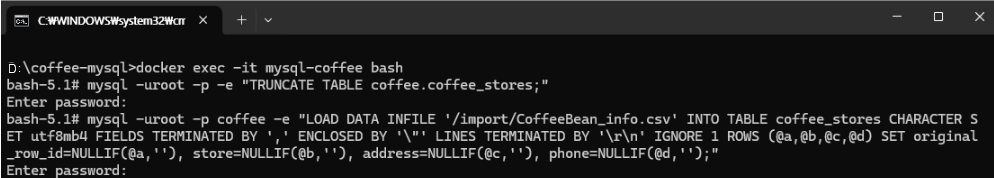

## 자료 적재 후 내용 확인하기

```powershell
# 컨테이너로 로그인
docker exec -it mysql-coffee bash
# 컨테이너 안에서 MySQL coffee 데이터베이스로 로그인
mysql -uroot -p --default-character-set=utf8mb4 coffee
# 자료 조회
select * from coffee_stores limit 10;
```

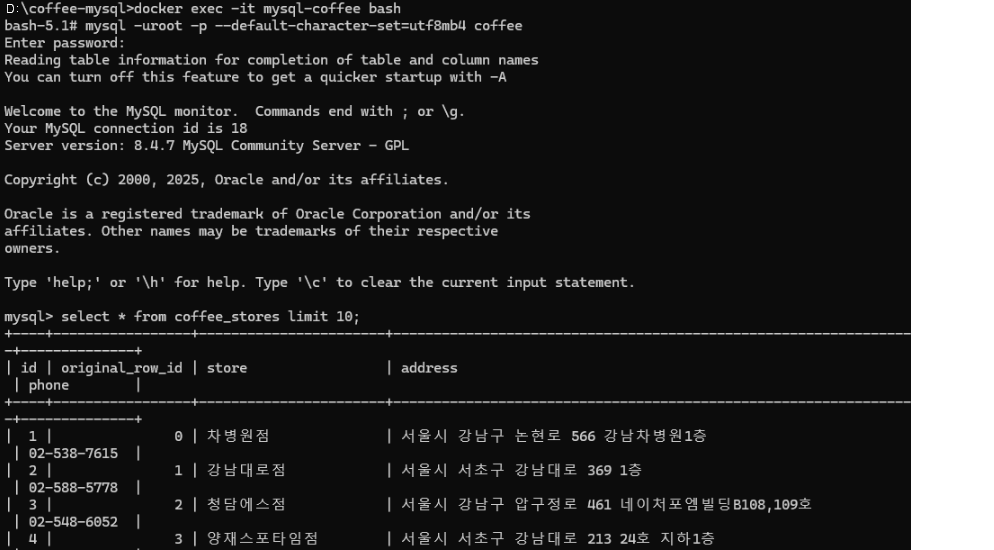

# 위 데이터베이스를 파이썬 코드로 컨트롤하기
* 관련 패키지 설치
  
```
pip install mysql-connector-python pymysql sqlalchemy pandas
```


In [ ]:
!pip install mysql-connector-python pymysql sqlalchemy pandas

## 기본 정보 확인
* host: 127.0.0.1 (또는 localhost)
* port: 3306
* user: root
* password: rootpw123! 
* database: coffee
* charset: utf8mb4

## 예시 코드

```python
import mysql.connector as mysql

conn = mysql.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="rootpw123!",
    database="coffee",
    charset="utf8mb4",          # 중요: 한글용
    use_unicode=True
)

try:
    cur = conn.cursor(dictionary=True)  # dict로 받으면 컬럼명으로 접근 쉬움
    cur.execute("SELECT COUNT(*) AS cnt FROM coffee_stores;")
    print("row count:", cur.fetchone()["cnt"])

    # 예: 상위 10행 조회
    cur.execute("""
        SELECT id, original_row_id, store, address, phone
        FROM coffee_stores
        ORDER BY id
        LIMIT 10
    """)
    rows = cur.fetchall()
    for r in rows:
        print(r["id"], r["store"], r["address"], r["phone"])

finally:
    conn.close()
```

In [ ]:
import mysql.connector as mysql

conn = mysql.connect(
    host="127.0.0.1",
    port=3306,
    user="root",
    password="rootpw123!",
    database="coffee",
    charset="utf8mb4",          # 중요: 한글용
    use_unicode=True
)

try:
    cur = conn.cursor(dictionary=True)  # dict로 받으면 컬럼명으로 접근 쉬움
    cur.execute("SELECT COUNT(*) AS cnt FROM coffee_stores;")
    print("row count:", cur.fetchone()["cnt"])

    # 예: 상위 10행 조회
    cur.execute("""
        SELECT id, original_row_id, store, address, phone
        FROM coffee_stores
        ORDER BY id
        LIMIT 10
    """)
    rows = cur.fetchall()
    for r in rows:
        print(r["id"], r["store"], r["address"], r["phone"])

finally:
    conn.close()